In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
from utils import *
from rnnv2 import *

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [3]:
def findFiles(path):
    return glob.glob(path)

In [4]:
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines] 

In [5]:
category_lines = {}
all_categories = []
for filename in findFiles('./data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
    'from https://download.pytorch.org/tutorial/data.zip and extract it to '
    'the current directory.')
    
print('# categories: ', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories:  18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [6]:
import random

In [7]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [8]:
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [9]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [10]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [11]:
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [12]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [13]:
randomTrainingExample()

(tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 

In [17]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [18]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
rnn = RNNv2(n_letters, 128, n_letters, n_categories)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print(f'{timeSince(start)} ({iter} {iter / n_iters * 100}%) {loss}')
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (5000 5.0%) 3.297487258911133
0m 16s (10000 10.0%) 3.0201010704040527
0m 24s (15000 15.0%) 2.1686344146728516
0m 32s (20000 20.0%) 3.5617701212565103
0m 40s (25000 25.0%) 4.099557240804036
0m 48s (30000 30.0%) 1.9774576822916667
0m 56s (35000 35.0%) 2.6542161305745444
1m 4s (40000 40.0%) 2.049287584092882
1m 12s (45000 45.0%) 2.937549591064453
1m 20s (50000 50.0%) 2.5903069178263345
1m 28s (55000 55.00000000000001%) 2.080784388950893
1m 36s (60000 60.0%) 2.6196422576904297
1m 44s (65000 65.0%) 1.2621945142745972
1m 52s (70000 70.0%) 1.6887914339701335
2m 0s (75000 75.0%) 1.8551887784685408
2m 8s (80000 80.0%) 2.473595210484096
2m 16s (85000 85.0%) 2.498011997767857
2m 24s (90000 90.0%) 2.1648399353027346
2m 32s (95000 95.0%) 2.108012040456136
2m 40s (100000 100.0%) 2.676798105239868


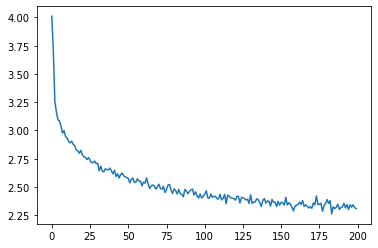

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [25]:
max_length = 20

def sample(category, start_letter = 'A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name

In [26]:
def samples(category, start_letters = 'ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [29]:
samples('Russian', 'RUS')

Roshin
Uakin
Sakovak
